# MCMC

### import package

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import corner
import os

from numpy.random import random

from scipy.optimize import minimize
from scipy.signal import savgol_filter
from scipy.interpolate import CubicSpline
from scipy.fft import fft, fftfreq

from lib.Model import Model, histMCMC, Numerical_Model

In [2]:
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 13,
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{amsfonts}",
    "figure.dpi": 200,
    "figure.figsize": (12,5),
    "lines.linewidth": 1,
})

In [3]:
# 顯示所有 csv 檔案
!ls data

2023-6-12-20-53.csv 2023-6-12-22-3.csv  2023-6-13-11-11.csv 2023-6-13-12-1.csv
2023-6-12-21-0.csv  2023-6-12-22-37.csv 2023-6-13-11-9.csv  2023-6-13-12-2.csv
2023-6-12-21-10.csv 2023-6-13-11-10.csv 2023-6-13-12-0.csv


### Read CSV data and Plot

Record the better result setting
- data `2023-6-13-12-0.csv`
    1. time interval : $t = 0\sim 2$
    2. Error type : $E_{\rm MSE}$ Mean Square Error
    3. Probability : $P = \exp(-E_{\rm MSE})$
    4. Transformation : $P \to P^{200000} \approx \exp(200000\cdot(P-1))$
    5. MCMC Number : $N=100000$
    6. MCMC delta : $\delta = 10.0$ 
- data `2023-6-13-12-9.csv`
    1. time interval : $t = 0\sim 2$
    2. Error type : $E_{\rm MSE}$ Mean Square Error
    3. Probability : $P = \exp(-E_{\rm MSE})$
    4. Transformation : $P \to P^{200000} \approx \exp(200000\cdot(P-1))$
    5. MCMC Number : $N=100000$
    6. MCMC delta : $\delta = 10.0$ 
- data `2023-6-12-22-37.csv`
    1. time interval : $t = 0\sim 2$
    2. Error type : $E_{\rm MSE}$ Mean Square Error
    3. Probability : $P = \exp(-E_{\rm MSE})$
    4. Transformation : $P \to P^{200000} \to \exp(1000000\cdot(P-1))\cdot 1000$
    5. MCMC Number : $N=100000$
    6. MCMC delta : $\delta = 10.0$ 

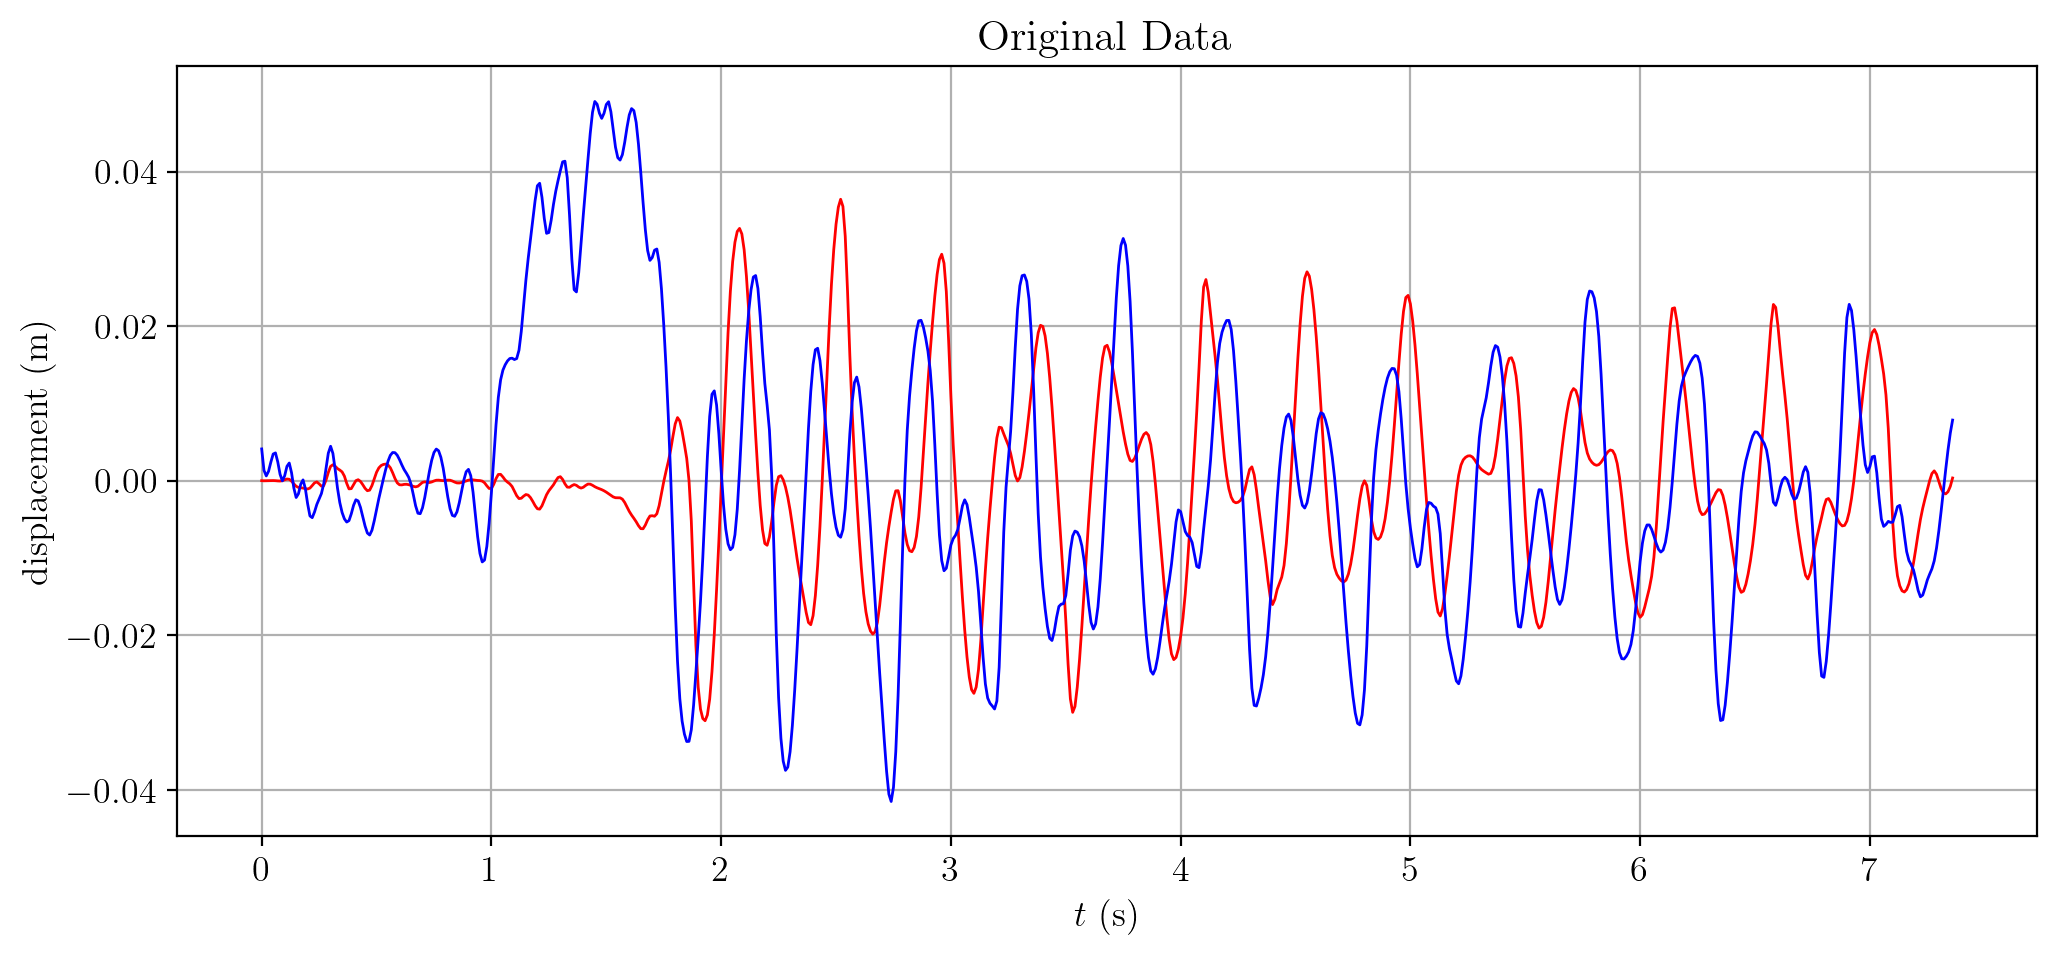

In [4]:
# 讀取資料
name = "2023-6-13-12-0"
data = pd.read_csv(f"./data/{name}.csv", header=None) 

if not os.path.exists(f"result/{name}"):
    os.makedirs(f"result/{name}")
if not os.path.exists(f"result/{name}/figure"):
    os.makedirs(f"result/{name}/figure")

# 儲存資料
time_sec_ = data[0].to_numpy()  # (sec)
x1_laser_ = data[1].to_numpy() *  0.01 # (cm -> m)
x2_laser_ = data[2].to_numpy() * -0.01 # (cm -> m)

x1_sound_ = data[3].to_numpy() *  0.01 # (cm -> m)
x2_sound_ = data[4].to_numpy() * -0.01 # (cm -> m)

# 震幅平移，平均為 0
x1_laser_ = x1_laser_ - np.mean(x1_laser_)
x2_laser_ = x2_laser_ - np.mean(x2_laser_)
x1_sound_ = x1_sound_ - np.mean(x1_sound_)
x2_sound_ = x2_sound_ - np.mean(x2_sound_)

# 時間平移，第一項為 0 
time_sec_ = time_sec_ - time_sec_[0]

# 數據平滑
win_size = 5
x1 = savgol_filter(x1_sound_, win_size, 3)
x2 = savgol_filter(x2_sound_, win_size, 3)

# 數據差值
x1_spline = CubicSpline(time_sec_, x1)
x2_spline = CubicSpline(time_sec_, x2)

t = np.arange(0,max(time_sec_),0.01)

fig = plt.figure()
plt.title("Original Data")
plt.plot(t,x1_spline(t),'-',color='red')
plt.plot(t,x2_spline(t),'-',color='blue')
plt.ylabel("displacement (m)")
plt.xlabel("$t$ (s)")
plt.grid()
plt.show()

# fig.savefig(f"./result/{name}/figure/original.svg", format="svg")

# Plot data near start time

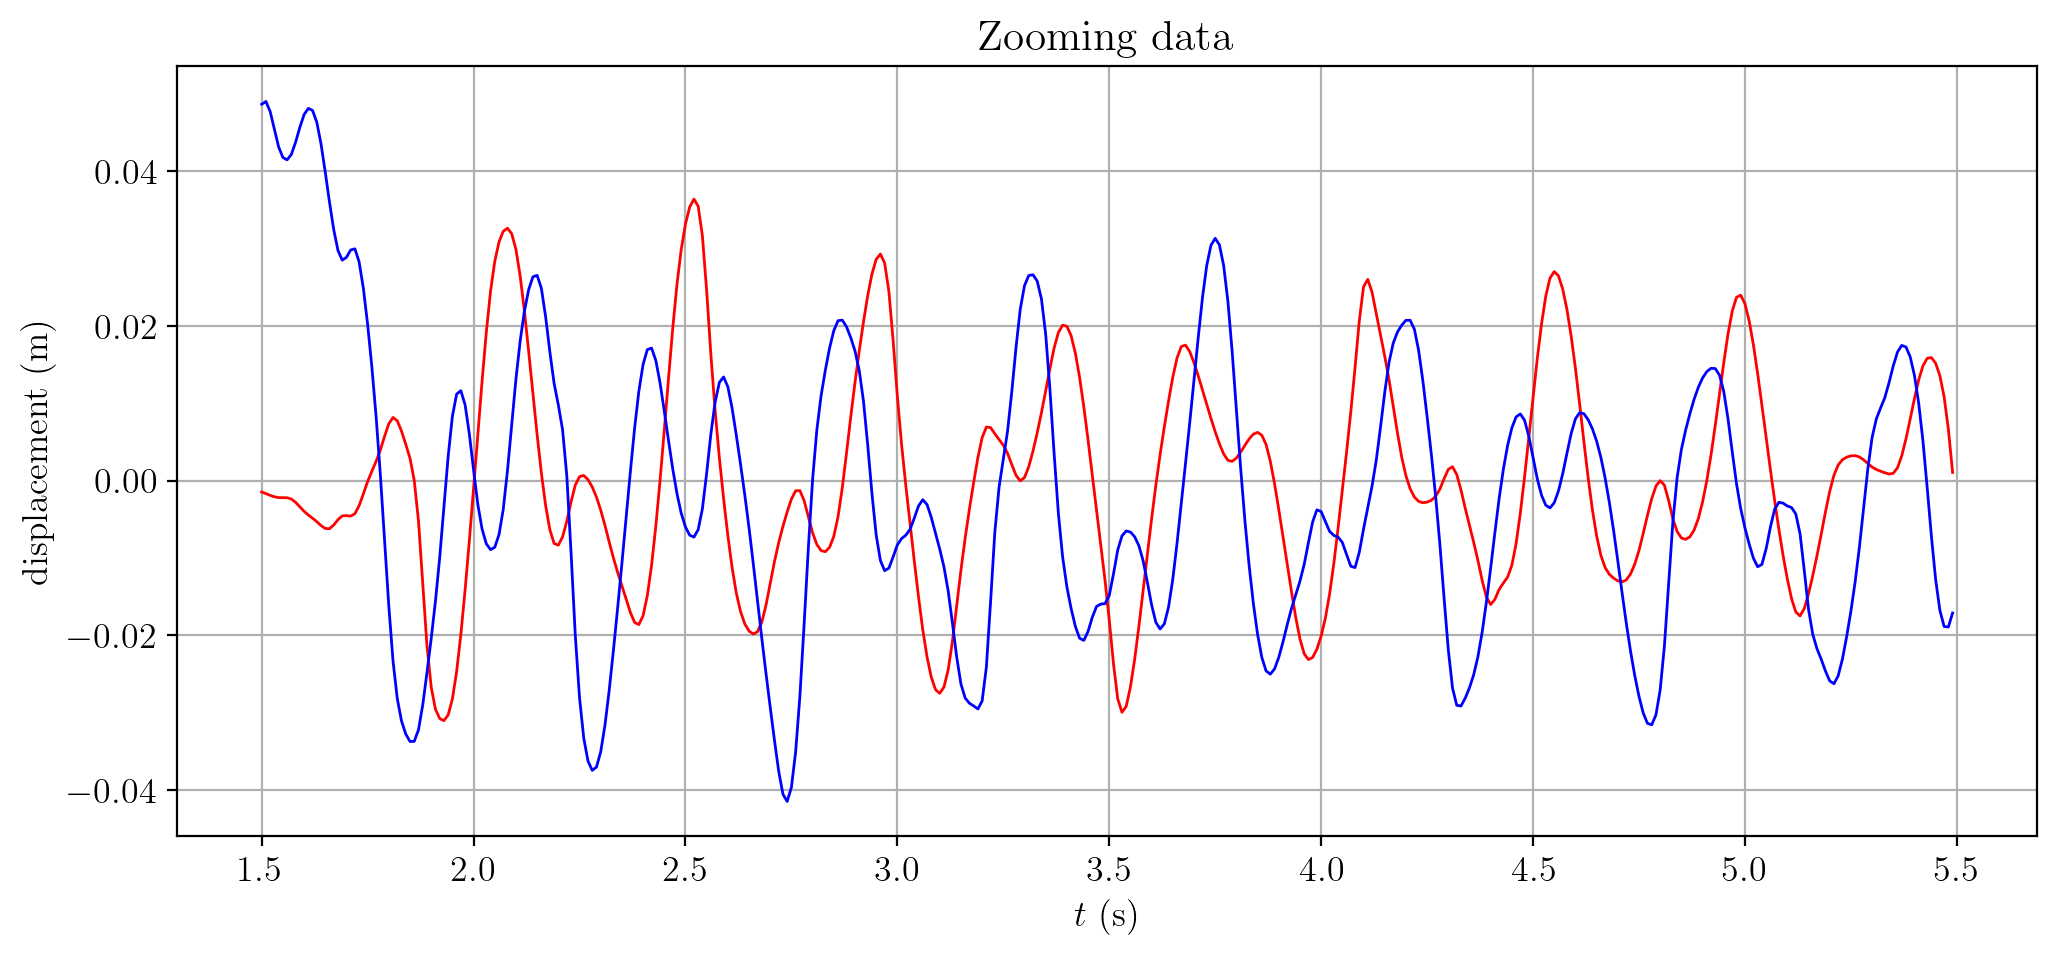

In [5]:
t_min = 1.5
t_max = 5.5
t = np.arange(t_min, t_max, 0.01)

fig = plt.figure()
plt.title("Zooming data")
plt.plot(t,x1_spline(t),'-',color='red')
plt.plot(t,x2_spline(t),'-',color='blue')
plt.ylabel("displacement (m)")
plt.xlabel("$t$ (s)")
plt.grid()
plt.show()
# fig.savefig(f"./result/{name}/figure/zooming.svg", format="svg")

## choose $t_0$ and Plot

(-0.031646499153020896, -0.002686915603295862) (-0.16336723541426576, 0.8364449191274239)


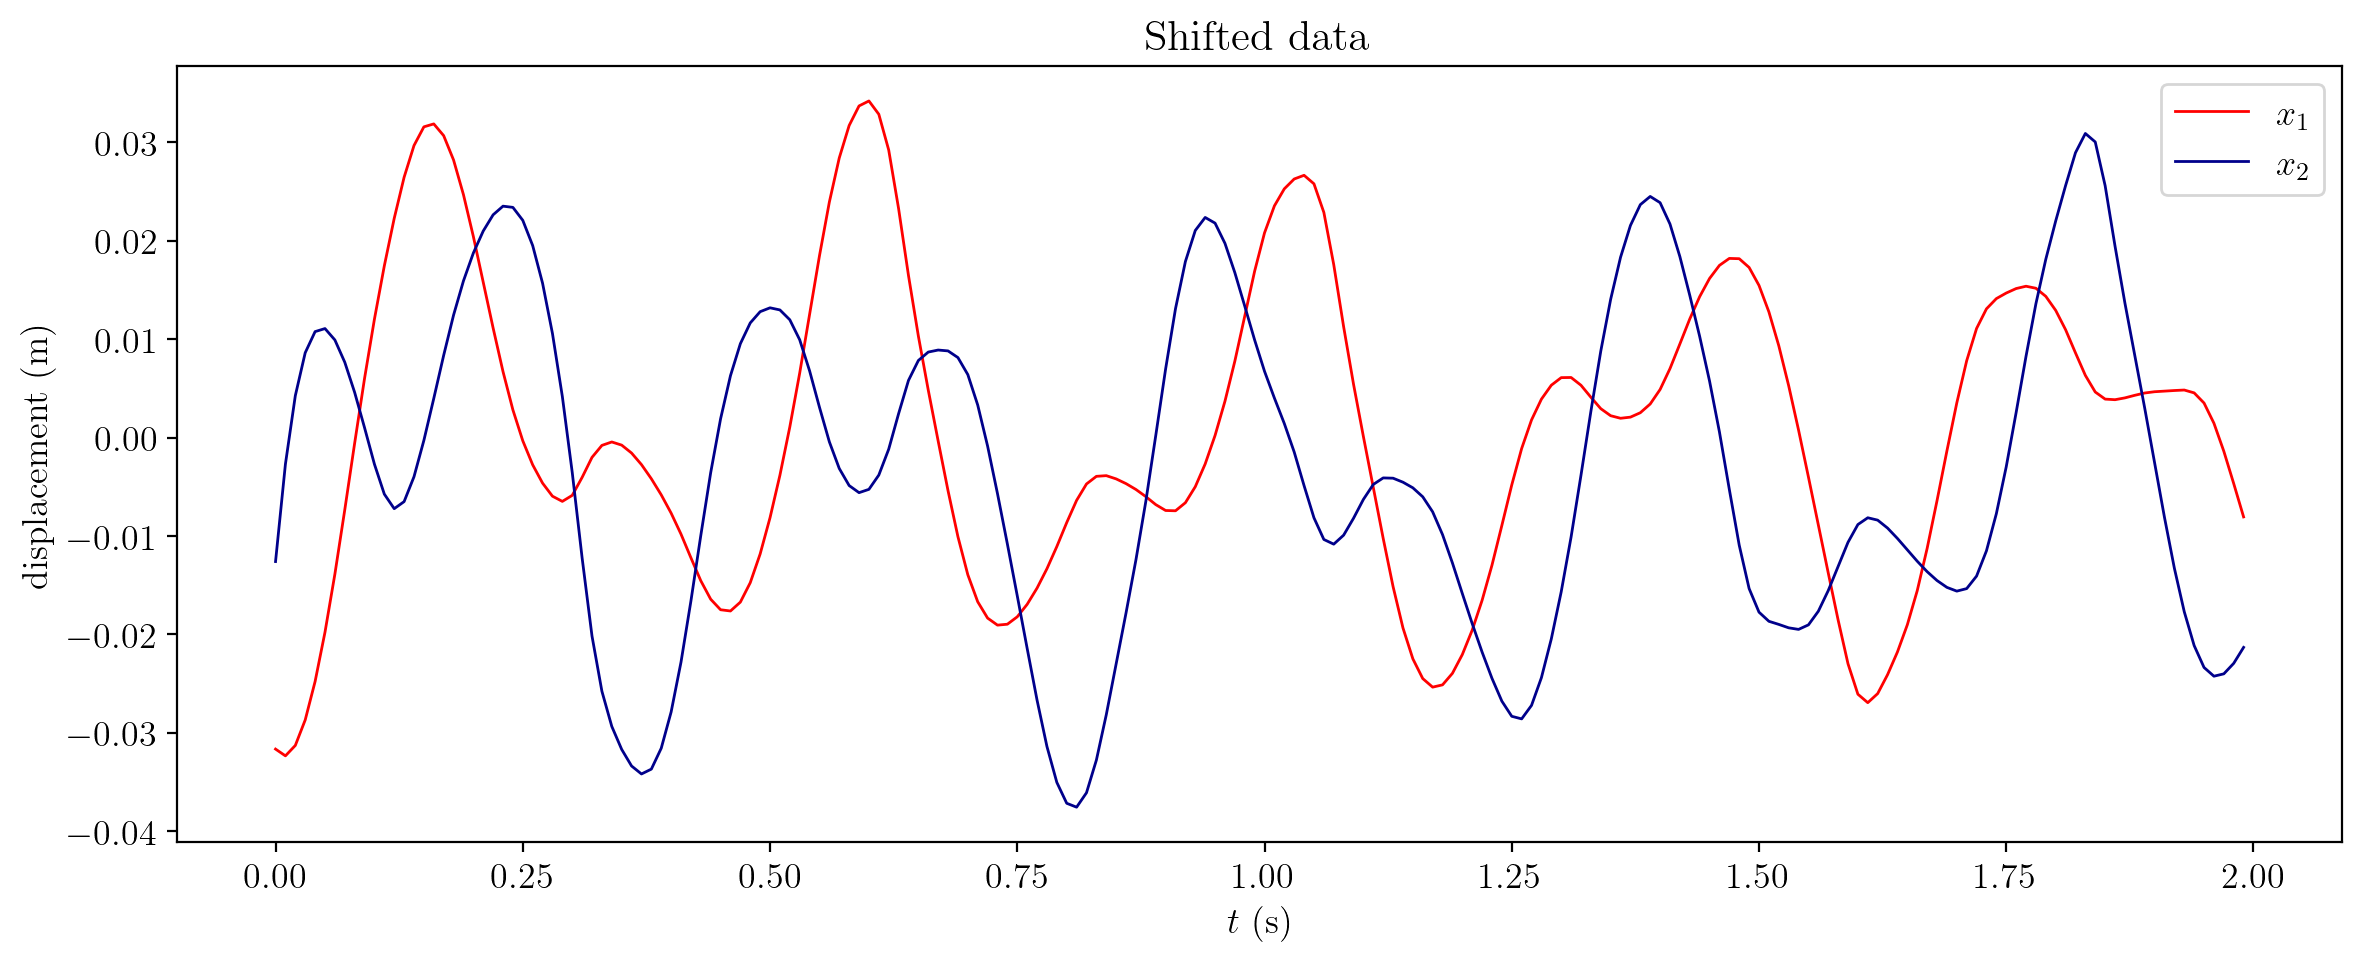

In [6]:
t0 = 1.9

t0_index = np.argmax(time_sec_ > t0)

time_sec = time_sec_[t0_index:]
x1_laser = x1_laser_[t0_index:]
x2_laser = x2_laser_[t0_index:]
x1_sound = x1_sound_[t0_index:]
x2_sound = x2_sound_[t0_index:]

# 時間平移，第一項為 0 
time_sec = time_sec - time_sec[0]

# 數據平滑
win_size = 7
x1 = savgol_filter(x1_sound, win_size, 3)
x2 = savgol_filter(x2_sound, win_size, 3)

# 數據差值
x1_spline = CubicSpline(time_sec, x1)
x2_spline = CubicSpline(time_sec, x2)

# x1_spline = CubicSpline(time_sec, x1_sound)
# x2_spline = CubicSpline(time_sec, x2_sound)

v1_spline = x1_spline.derivative()
v2_spline = x2_spline.derivative()


t_end = time_sec[-1]
t_end = 2
t = np.arange(0, t_end, 0.01)
x1_data = x1_spline(t)
x2_data = x2_spline(t)
v1_data = v1_spline(t)
v2_data = v2_spline(t)
m = (0.7216,0.6950)
xi = (x1_data[0], x2_data[1])
vi = (v1_data[0], v2_data[1])
print(xi,vi)
fig = plt.figure()

plt.title("Shifted data")
plt.plot(t,x1_data, color='red',label="$x_1$",markersize=2,linewidth=1)
plt.plot(t,x2_data, color='darkblue',label="$x_2$",markersize=2,linewidth=1)
plt.ylabel("displacement (m)")
plt.xlabel("$t$ (s)")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# fig.savefig(f"./result/{name}/figure/shifted.svg", format="svg")

## Fourier transform

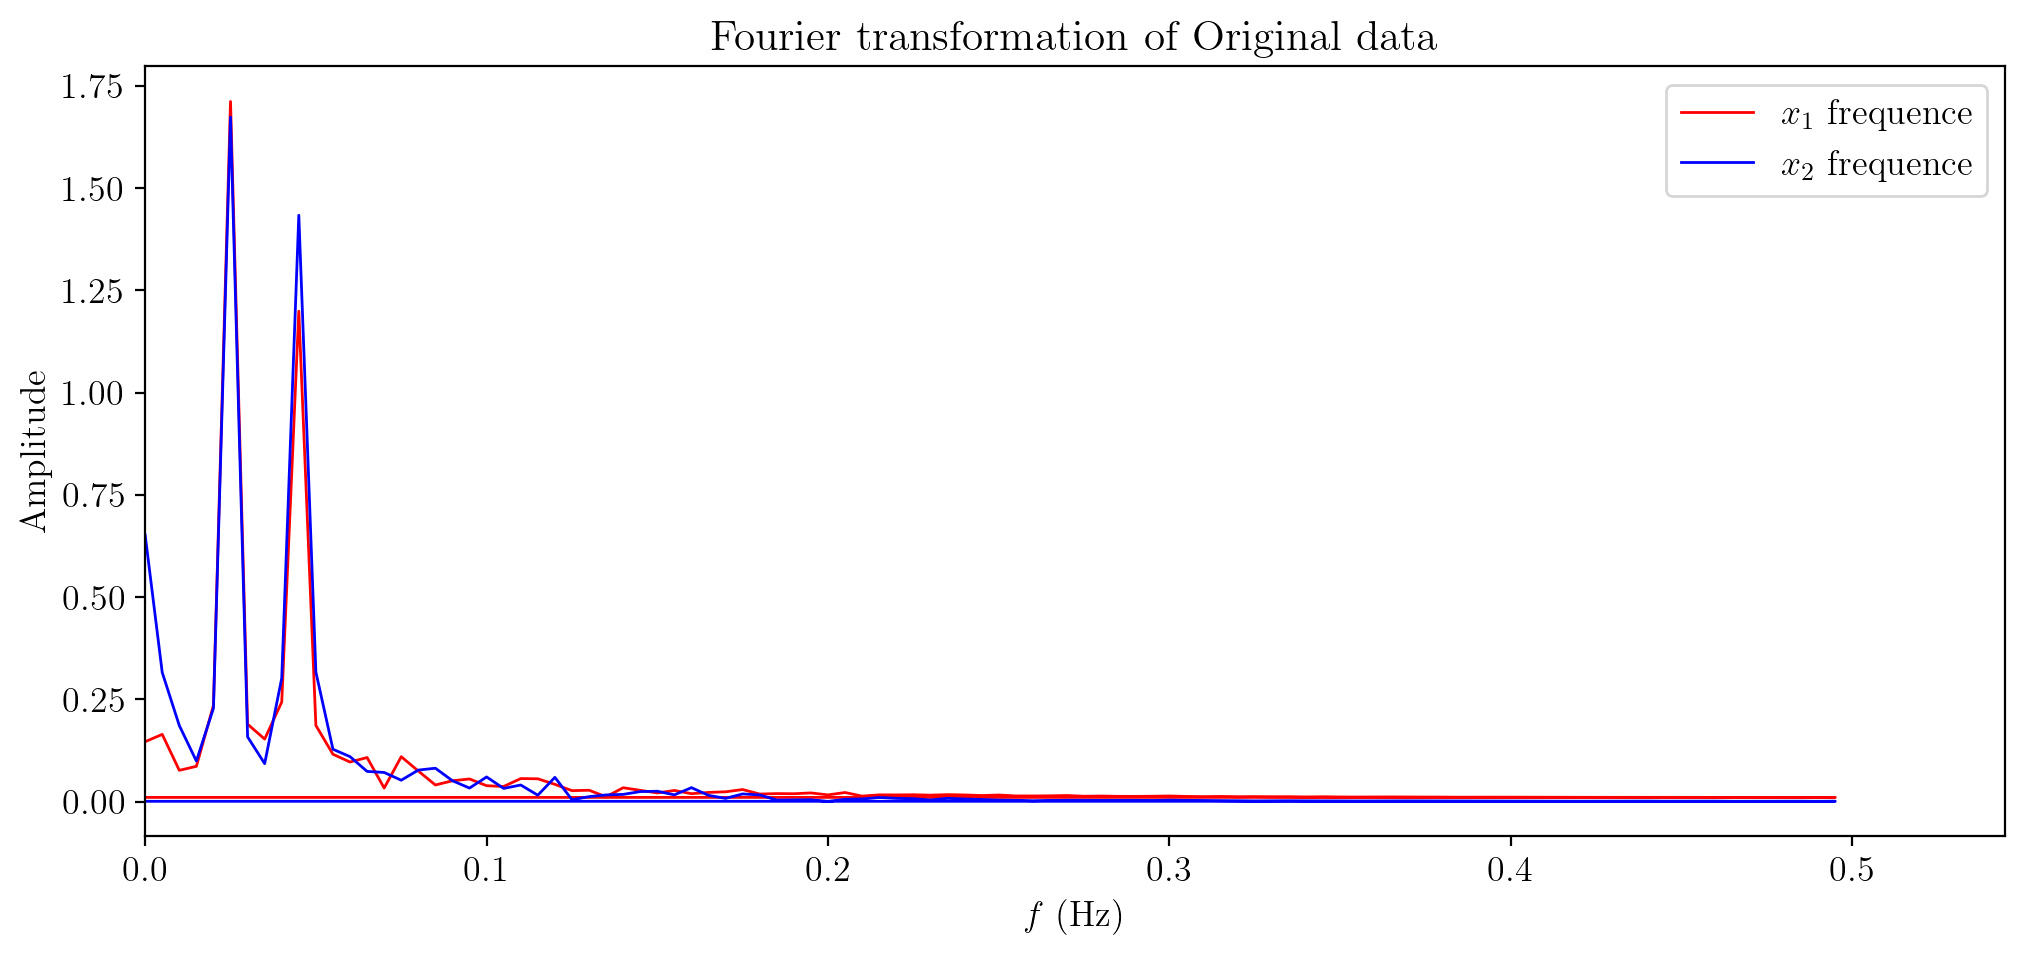

In [7]:
freq = fftfreq(len(t))
A_f1 = fft(x1_data)
A_f2 = fft(x2_data)

fig = plt.figure()
plt.title("Fourier transformation of Original data")
plt.plot(freq, np.abs(A_f1),"red", label="$x_1$ frequence")
plt.plot(freq, np.abs(A_f2),"blue", label="$x_2$ frequence")
plt.xlim(0,)
plt.legend()
plt.xlabel("$f$ (Hz)")
plt.ylabel("Amplitude")
plt.show()

# fig.savefig(f"./result/{name}/figure/frequence.svg", format="svg")

### MCMC

In [8]:
def freq_MSE(t, k, x1_data, x2_data, m, xi, vi):
    N = len(t)
    x1_theo, x2_theo, v1_theo ,v2_theo = Model(t, k, m, xi, vi)
    F1_data = fft(x1_data)
    F2_data = fft(x2_data)
    F1_theo = fft(x1_theo)
    F2_theo = fft(x2_theo)
    MSE1 = np.sum(abs((F1_data - F1_theo))**2) / N
    MSE2 = np.sum(abs((F2_data - F2_theo))**2) / N
    return MSE1+MSE2

def pos_MSE(t, k, x1_data, x2_data, m, xi, vi):
    N = len(t)
    x1_theo, x2_theo, v1_theo ,v2_theo = Model(t, k, m, xi, vi)
    MSE1 = np.sum(abs((x1_data - x1_theo))**2) / N
    MSE2 = np.sum(abs((x2_data - x2_theo))**2) / N
    return MSE1+MSE2

def Prob(MSE):
    P = np.exp(-MSE)
    return np.exp(200000*(P-1))*1e25

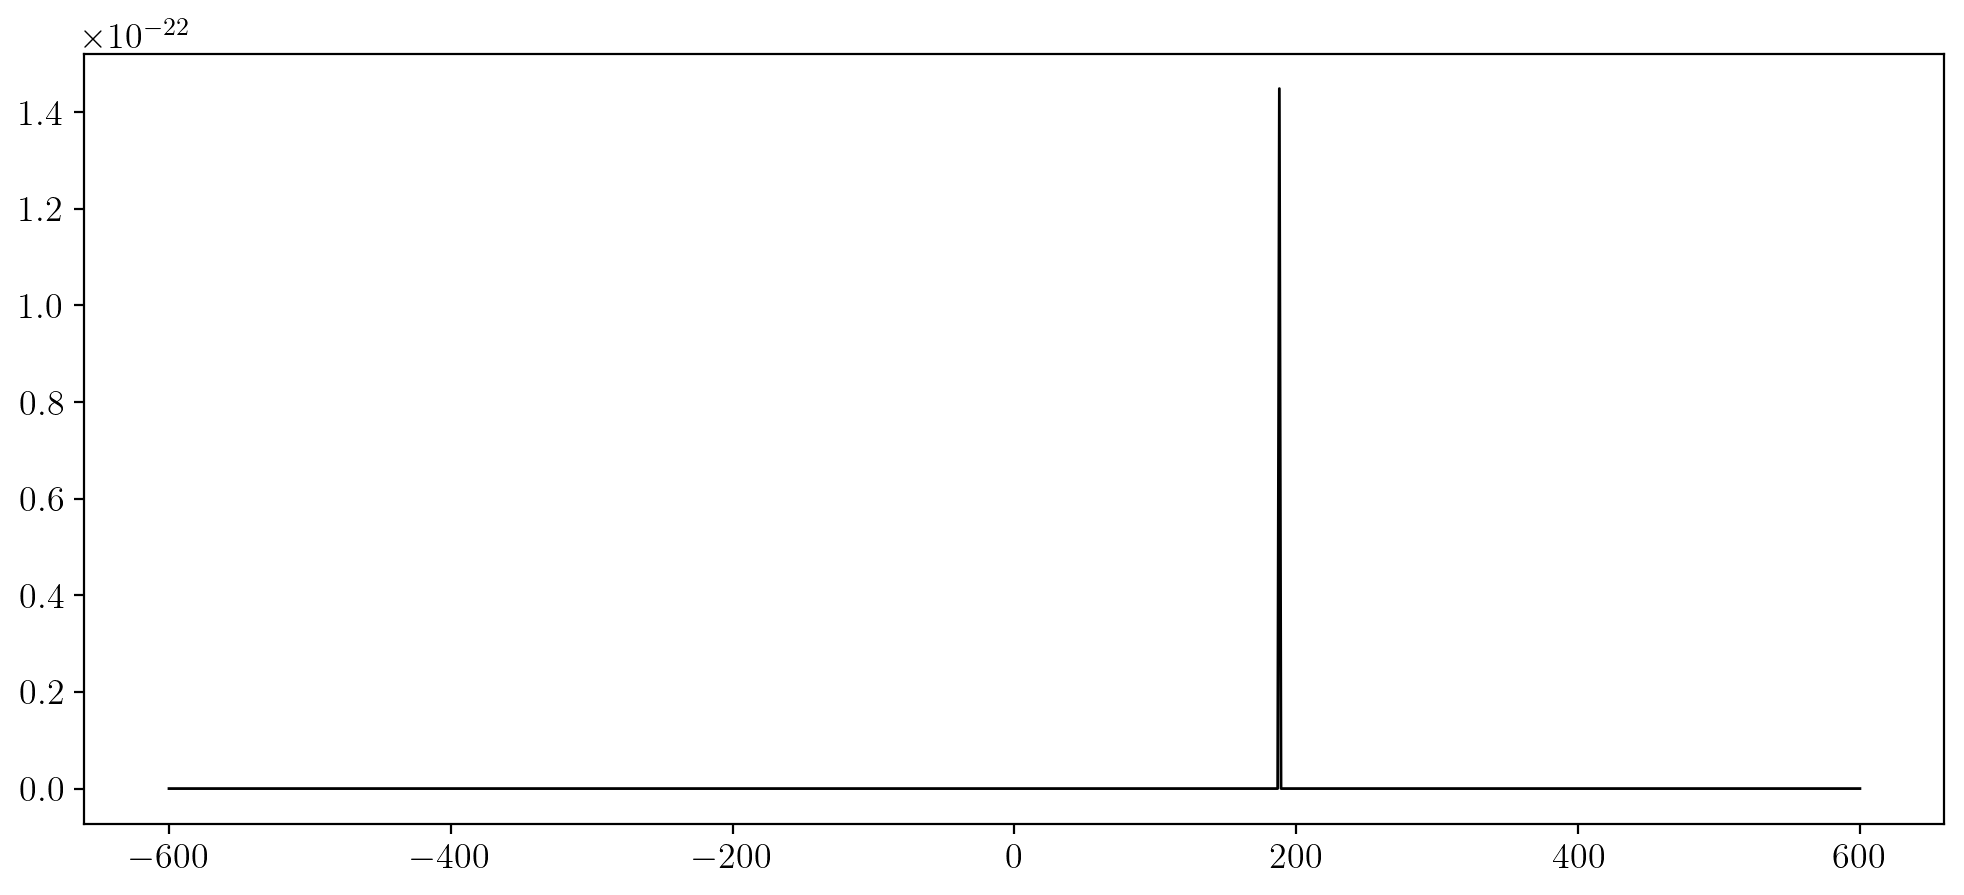

In [9]:
k1 = np.linspace(-600, 600, 1000)
k2 = 180*(1 + k1*0) #(2*random(1000)-1)*600
k3 = 180*(1 + k1*0) #(2*random(1000)-1)*600

k2 = (2*random(1000)-1)*600
k3 = (2*random(1000)-1)*600

Probs_landscape = np.zeros(len(k1))
for i in range(len(k1)):
    MSE = pos_MSE(t, (k1[i], k2[i], k3[i]), x1_data, x2_data, m, xi, vi)
    Probs_landscape[i] = Prob(MSE)

plt.figure()
plt.plot(k1, Probs_landscape, color="black")
plt.show()

[200 200 200]
acceptance rate : 0.24290
[ 98.25543941 170.53955275 273.52643292]
acceptance rate : 0.23870


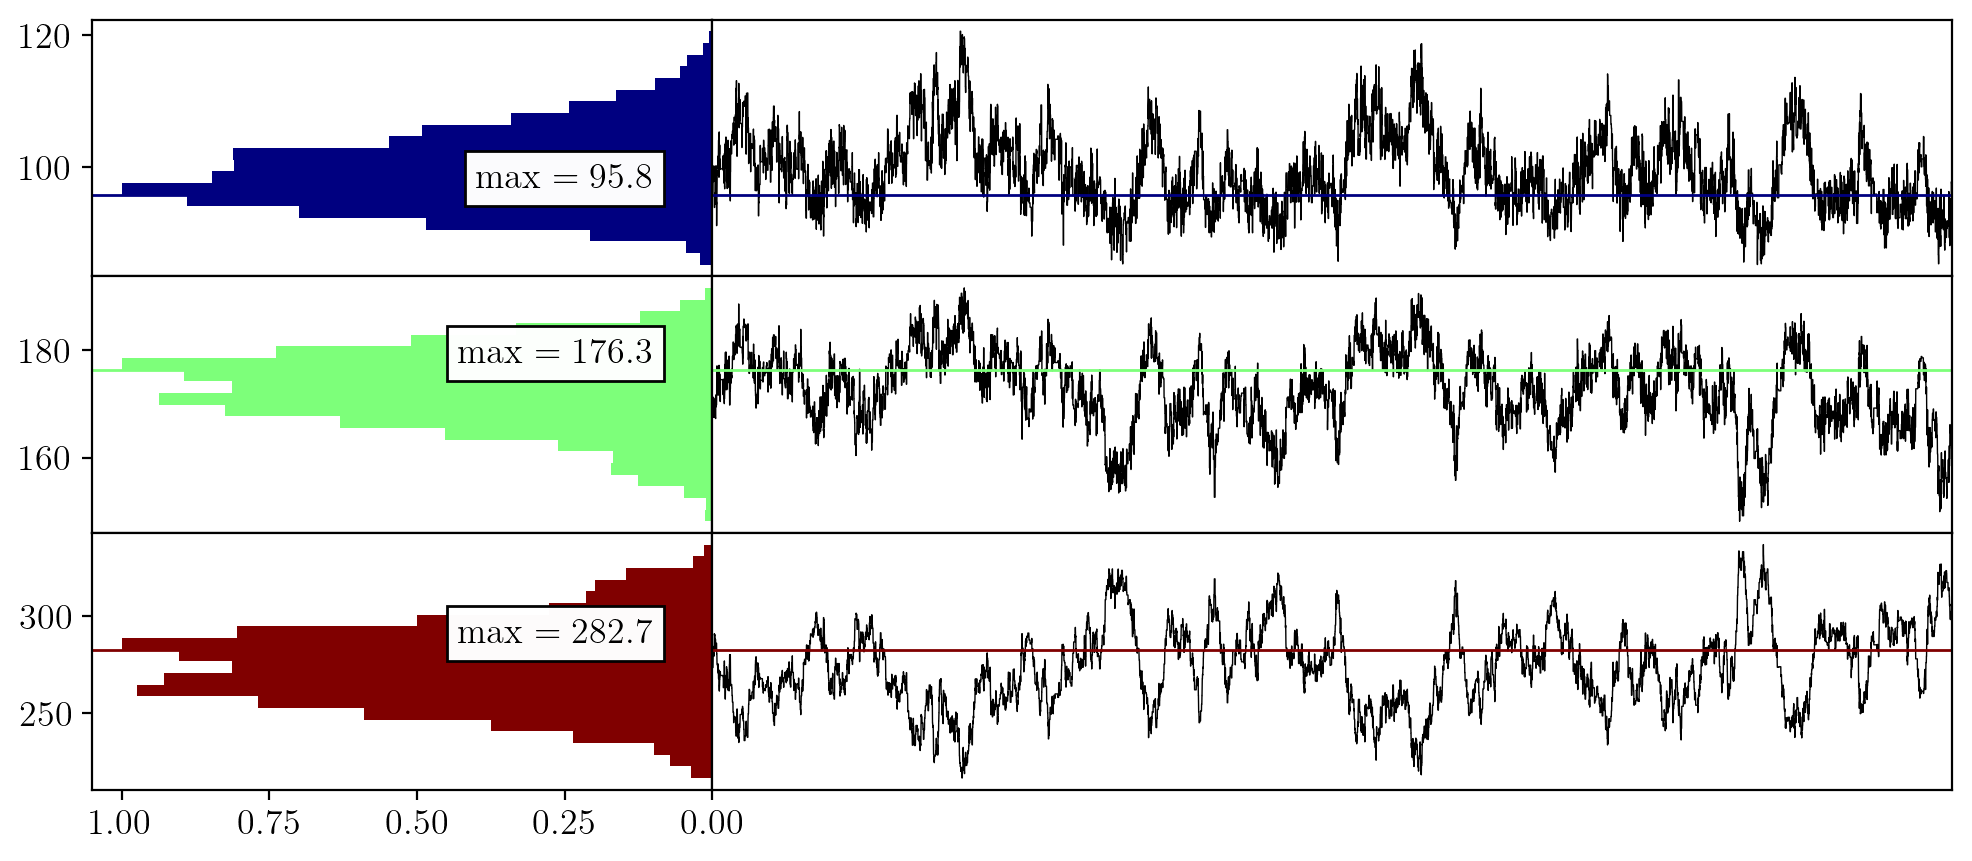

In [10]:
paras = np.array([200, 200, 200])

delta = 6.0
accN = 0
acc_rate = 0

print(paras)
for i in range(10000):
    paras_ = paras + delta * (2*random(3)-1)
    MSE  = pos_MSE(t, paras , x1_data, x2_data, m, xi, vi)
    MSE_ = pos_MSE(t, paras_, x1_data, x2_data, m, xi, vi)
    p  = Prob(MSE)
    p_ = Prob(MSE_)
    if(p_ >= p or random() < p_/p): 
        paras = paras_
        accN += 1
    acc_rate = accN/(i+1)
print(r"acceptance rate : %.5f"%acc_rate)

N = 20000
Paras = np.zeros([N, paras.size])
accN = 0
acc_rate = 0

print(paras)
for i in range(N):
    paras_ = paras + delta * (2*random(3)-1)
    MSE  = pos_MSE(t, paras , x1_data, x2_data, m, xi, vi)
    MSE_ = pos_MSE(t, paras_, x1_data, x2_data, m, xi, vi)
    p  = Prob(MSE)
    p_ = Prob(MSE_)
    if(p_ >= p or random() < p_/p): 
        paras = paras_
        accN += 1
    acc_rate = accN/(i+1)
    Paras[i] = paras
print(r"acceptance rate : %.5f"%acc_rate)

hist_result = histMCMC(Paras, bins=20, figsize=(12,5))
hist_result["figure"].savefig(f"./result/{name}/figure/MCMC_histogram.svg", format="svg")

In [43]:
Err = lambda paras: Prob(pos_MSE(t, paras , x1_data, x2_data, m, xi, vi))
for k in np.linspace(100, 300, 10, dtype=int):
    paras = (k,200,200)
    sol = minimize(Err, paras)
    print(sol.success, " : ", paras, " => ", sol.x)

True  :  (100, 200, 200)  =>  [100. 200. 200.]
True  :  (122, 200, 200)  =>  [121.74049047 204.55692958 200.53323433]
True  :  (144, 200, 200)  =>  [144. 200. 200.]
True  :  (166, 200, 200)  =>  [166. 200. 200.]
True  :  (188, 200, 200)  =>  [188. 200. 200.]
True  :  (211, 200, 200)  =>  [211. 200. 200.]
True  :  (233, 200, 200)  =>  [233. 200. 200.]
True  :  (255, 200, 200)  =>  [255. 200. 200.]
True  :  (277, 200, 200)  =>  [277. 200. 200.]
True  :  (300, 200, 200)  =>  [300. 200. 200.]


- data 可能不是independent，所以不能直接說...
- 但是這是一個方法，可以找出...

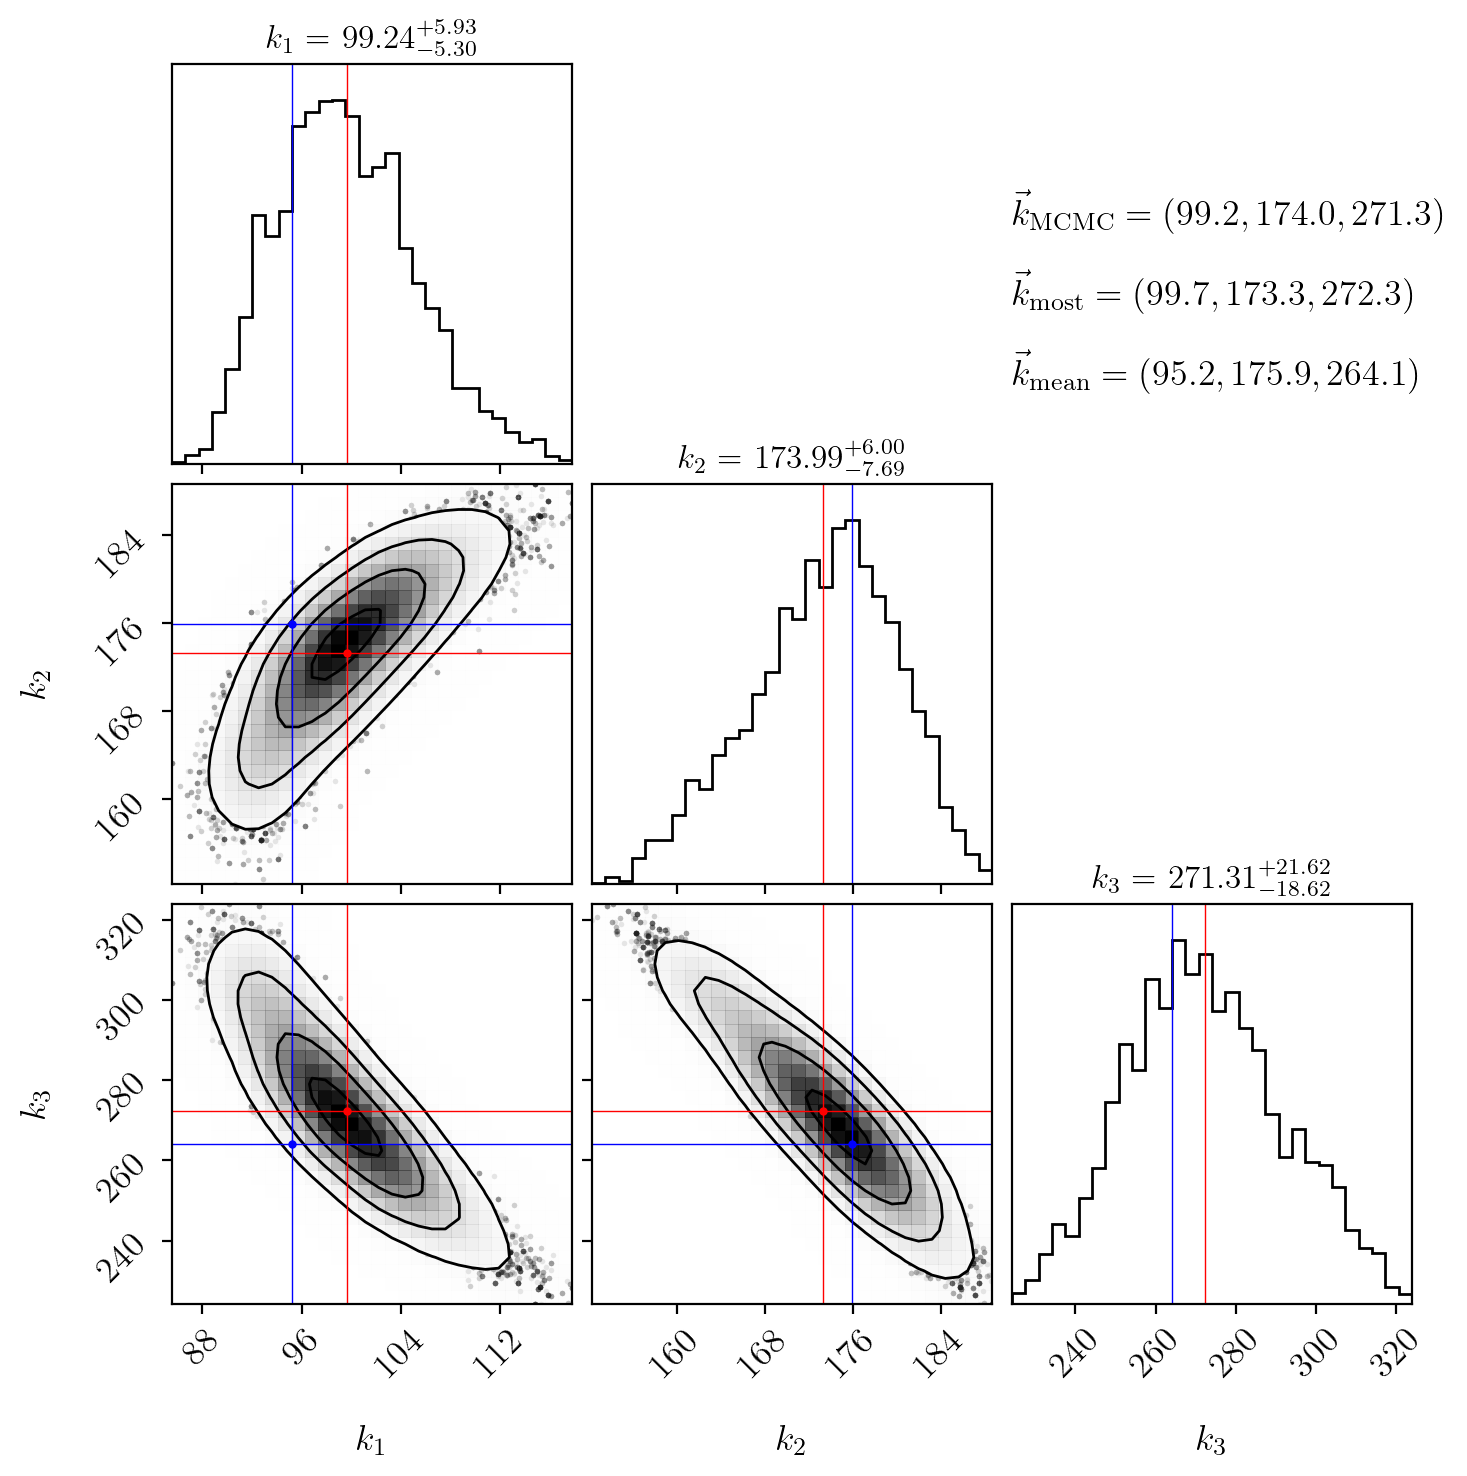

In [121]:
fig = corner.corner(
    Paras, 
    labels=["$k_1$", "$k_2$", "$k_3$"],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    dpi=100,
    smooth=2,
    bins=30,
)
corner.overplot_lines(fig, hist_result["mean"], color="red", linewidth=0.5)
corner.overplot_points(fig, hist_result["mean"][None], marker="o", color="red", markersize=2)
corner.overplot_lines(fig, hist_result["max"], color="blue", linewidth=0.5)
corner.overplot_points(fig, hist_result["max"][None], marker="o", color="blue", markersize=2)
hist_result["quantile"] = [corner.quantile(Paras[:,i], [0.16, 0.5, 0.84])[1] for i in range(paras.size)]

n = Paras[0,:].size
fig.axes[n-1].text(0.0,0.6,r"$\vec{k}_{\rm MCMC} =(%.1f,%.1f,%.1f)$"%tuple(hist_result["quantile"]))
fig.axes[n-1].text(0.0,0.4,r"$\vec{k}_{\rm most} =(%.1f,%.1f,%.1f)$"%tuple(hist_result["mean"]))
fig.axes[n-1].text(0.0,0.2,r"$\vec{k}_{\rm mean} =(%.1f,%.1f,%.1f)$"%tuple(hist_result["max"]))
fig.axes[n-1].set_xlim(0,1)
fig.axes[n-1].set_ylim(0,1)
plt.show()

fig.savefig(f"./result/{name}/figure/MCMC_corner.svg", format="svg")

## Compare

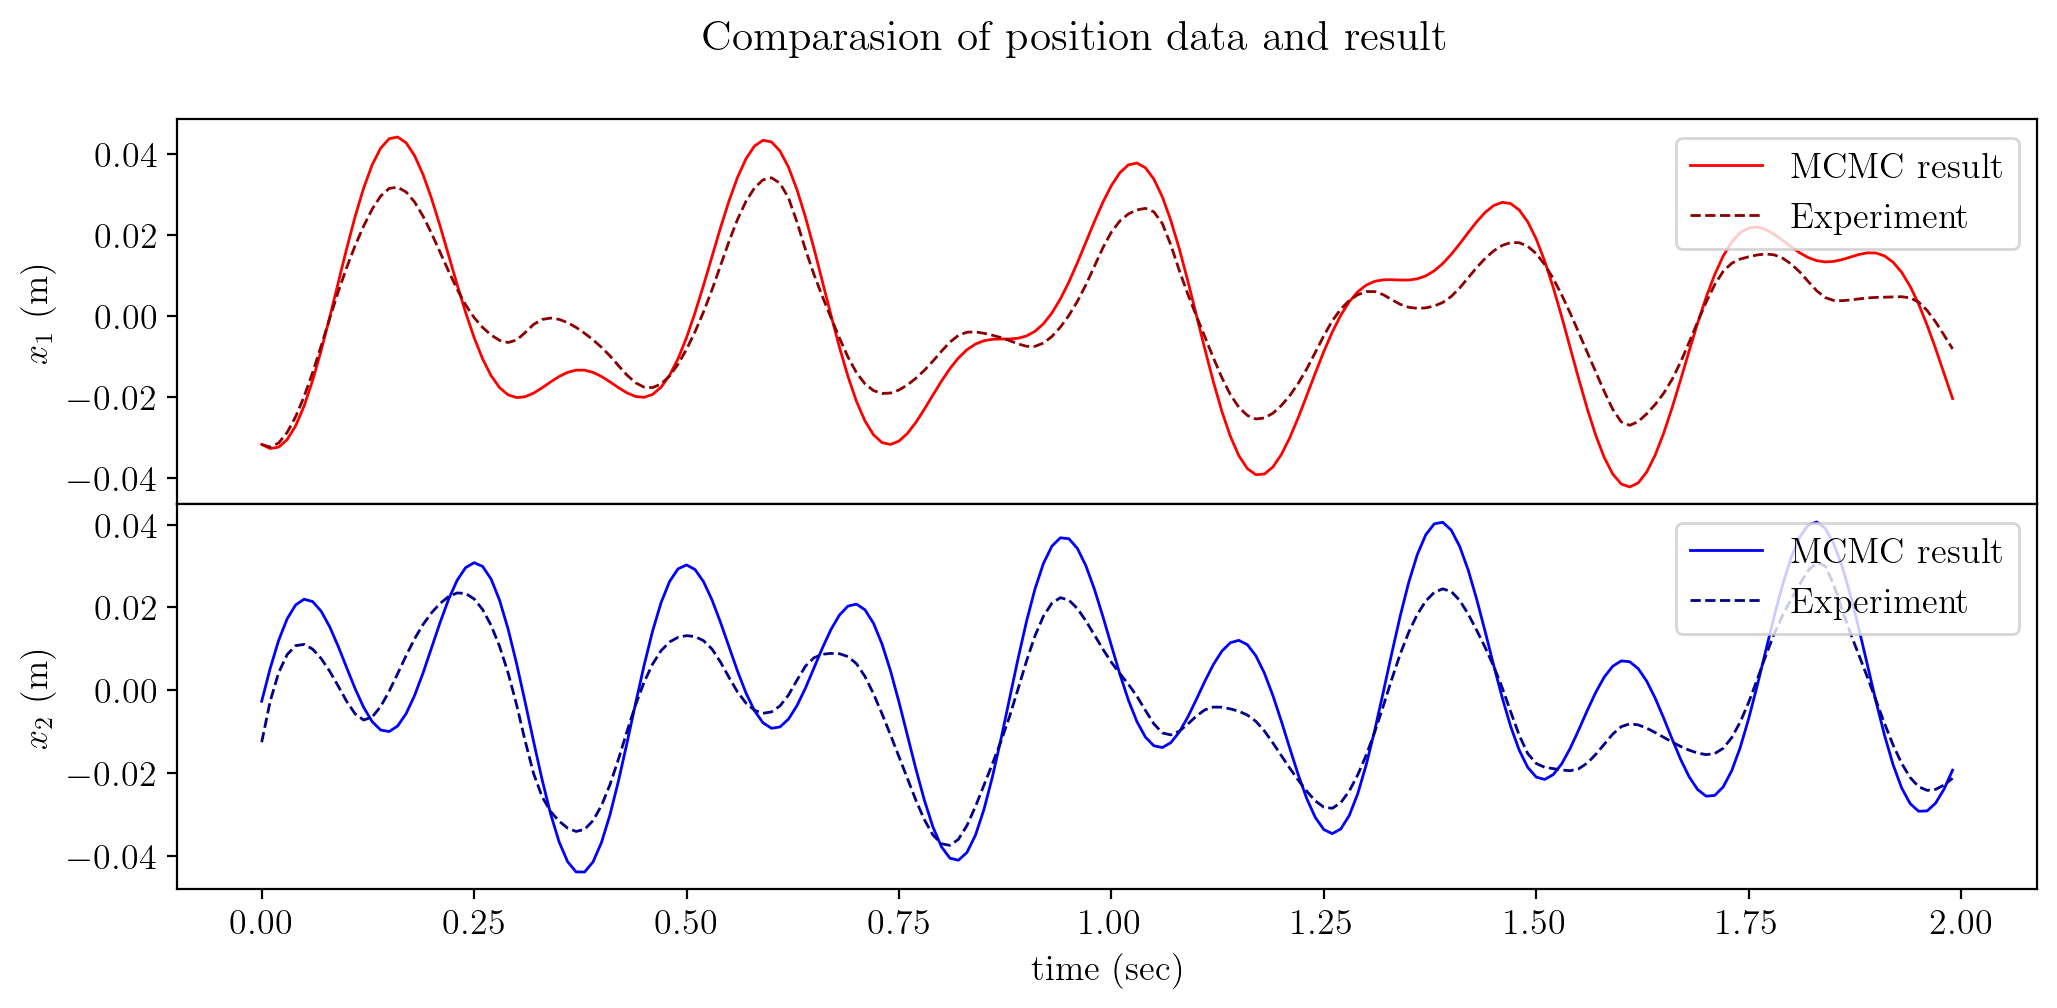

In [124]:
x1,x2,v1,v2 = Numerical_Model(t, hist_result["quantile"], m, xi, vi)

fig, axs = plt.subplots(2,1)
plt.suptitle("Comparasion of position data and result")

axs[0].plot(t,x1,color='red',label='MCMC result',markersize=2)
axs[0].plot(t,x1_data,'--',color='darkred',label='Experiment',markersize=2)
axs[0].legend(loc='upper right')
axs[0].set_ylabel("$x_1$ (m)")
axs[0].set_xticks([])


axs[1].plot(t,x2,color='blue',label='MCMC result',markersize=2)
axs[1].plot(t,x2_data,'--',color='darkblue',label='Experiment',markersize=2)
axs[1].legend(loc='upper right')
axs[1].set_ylabel("$x_2$ (m)")
axs[1].set_xlabel("time (sec)")

plt.subplots_adjust(hspace=0)
plt.show()

fig.savefig(f"./result/{name}/figure/position_compare.svg", format="svg")

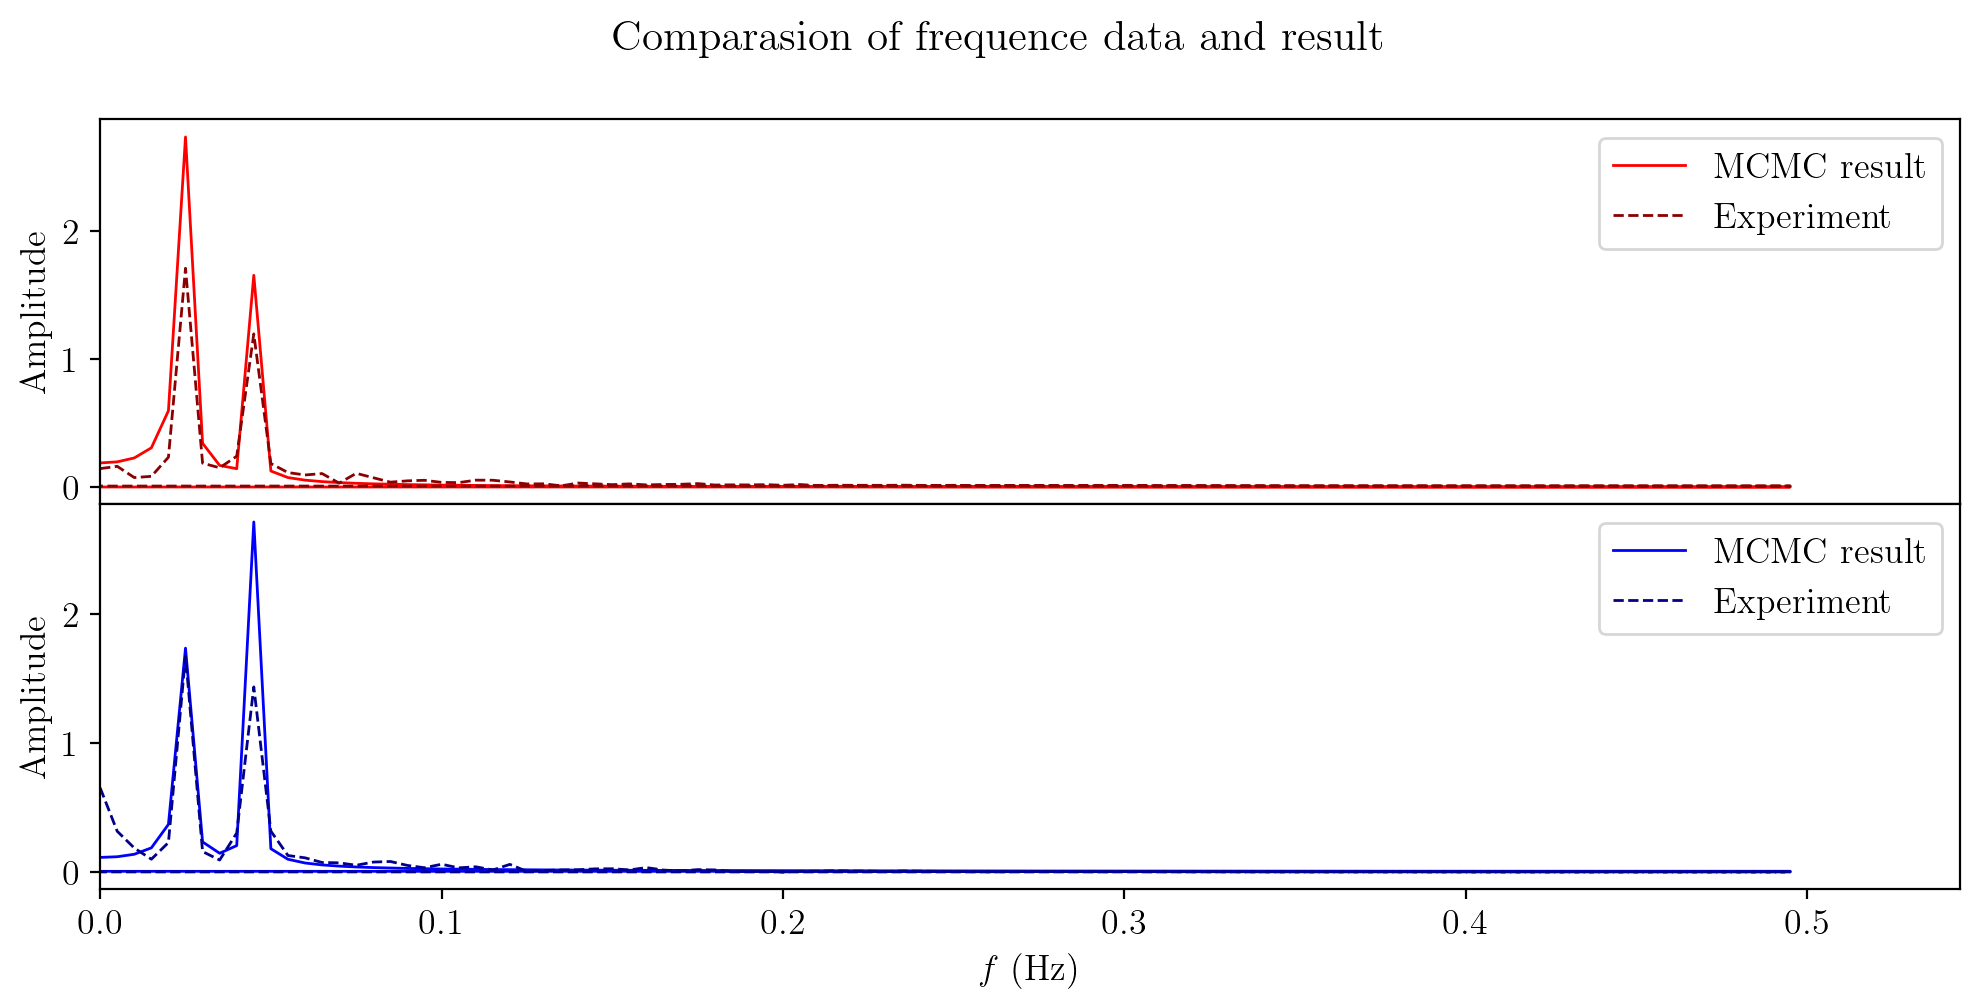

In [108]:
x1,x2,v1,v2 = Model(t, hist_result["quantile"], m, xi, vi)
freq = fftfreq(len(t))

fig, axs = plt.subplots(2,1)
plt.suptitle("Comparasion of frequence data and result")
axs[0].plot(freq, np.abs(fft(x1)),color='red',label='MCMC result',markersize=2)
axs[0].plot(freq, np.abs(fft(x1_data)),'--',color='darkred',label='Experiment',markersize=2)
axs[0].legend(loc='upper right')
axs[0].set_xticks([])
axs[0].set_ylabel("Amplitude")
axs[0].set_xlim(0,)


axs[1].plot(freq, np.abs(fft(x2)),color='blue',label='MCMC result',markersize=2)
axs[1].plot(freq, np.abs(fft(x2_data)),'--',color='darkblue',label='Experiment',markersize=2)
axs[1].legend(loc='upper right')
axs[1].set_xlabel("$f$ (Hz)")
axs[1].set_ylabel("Amplitude")
axs[1].set_xlim(0,)

plt.subplots_adjust(hspace=0)
plt.show()

fig.savefig(f"./result/{name}/figure/frequence_compare.svg", format="svg")

## Save

In [118]:
print(f"N = {N}")
print(f"t = [{t[0]},{t[1]},...,{t[-1]}]")
print(f"dt = {t[1]-t[0]}")

N = 100000
t = [0.0,0.01,...,1.99]
dt = 0.01
